In [1]:
#? load dependancies
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # hide tensorflow warnings

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical   
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4916718897149362455
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4936623712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4314246015751971533
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


In [2]:
#? Define constatns
XS_PATH      = './Xs.npy'
YS_PATH      = './ys.npy'
WEIGHTS_PATH = './weights.npy'
LABLES_PATH  = './lables.txt'

LEARNING_RATE = 0.1
EPOCHS        = 4
BATCH_SIZE    = 128

In [3]:
#? load the dataset, binarize the lables, and split it into training and testing arrays
Xs_raw       = np.load(XS_PATH).reshape((-1, 32, 32, 1))
ys_raw       = np.load(YS_PATH)
class_counts = np.load(WEIGHTS_PATH)

# binarize the lables
ys_binarized = to_categorical(ys_raw)

# split into a training and testing split
(x_train, x_test, y_train, y_test) = train_test_split(Xs_raw, ys_binarized, test_size=0.05, shuffle=True, random_state=42)

# normalize the class weights
class_weights = {}

for i in range(len(class_counts)):
    class_weights[i] = class_counts[i]

print(x_train.shape)
print(y_train.shape)
print(class_counts.shape)
print(class_weights)

(475442, 32, 32, 1)
(475442, 39)
(39,)
{0: 13869, 1: 8668, 2: 23409, 3: 10134, 4: 11440, 5: 1163, 6: 5762, 7: 7218, 8: 1120, 9: 8493, 10: 5603, 11: 11586, 12: 12336, 13: 19010, 14: 57825, 15: 19341, 16: 5812, 17: 11566, 18: 48419, 19: 22495, 20: 29008, 21: 4182, 22: 10784, 23: 6272, 24: 10859, 25: 6076, 26: 6000, 27: 6000, 28: 6000, 29: 6000, 30: 5999, 31: 6000, 32: 6000, 33: 6000, 34: 6000, 35: 6000, 36: 25112, 37: 33997, 38: 8908}


In [4]:
#? load the lables for each class
lables_raw = open(LABLES_PATH).read()
lables_split = lables_raw.split('\n')
lables = [chr((int)(c)) for c in lables_split]

print(lables)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '√']


In [5]:
#? construct an image generator for data augmentation
augmentor = ImageDataGenerator(
	rotation_range=5,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")

In [6]:
#? construct the ResNet50 model
opt = SGD(lr=LEARNING_RATE, decay=LEARNING_RATE/EPOCHS)

model = ResNet50(input_shape=(32, 32, 1), classes=y_train.shape[1], weights=None)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print(model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [7]:
#? train the model on the dataset
H = model.fit(
        augmentor.flow(x_train, y_train, batch_size=BATCH_SIZE), 
        validation_data=(x_test, y_test),
        epochs=EPOCHS,
        steps_per_epoch=len(x_train) // BATCH_SIZE,
        verbose=1)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3714/3714 [==============================] - ETA: 0s - loss: 1.1205 - accuracy: 0.7654WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000027344F09048> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

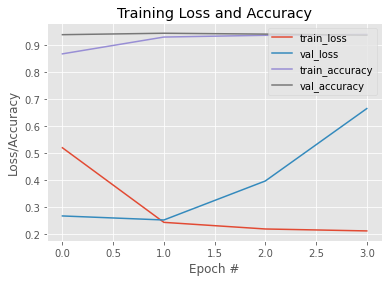

In [8]:
#? graph the loss and accuracy of the model over time
N = np.arange(0, EPOCHS)

plt.style.use("ggplot")
plt.figure()

plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_accuracy")
plt.plot(N, H.history["val_accuracy"], label="val_accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

plt.legend(loc="upper right")
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


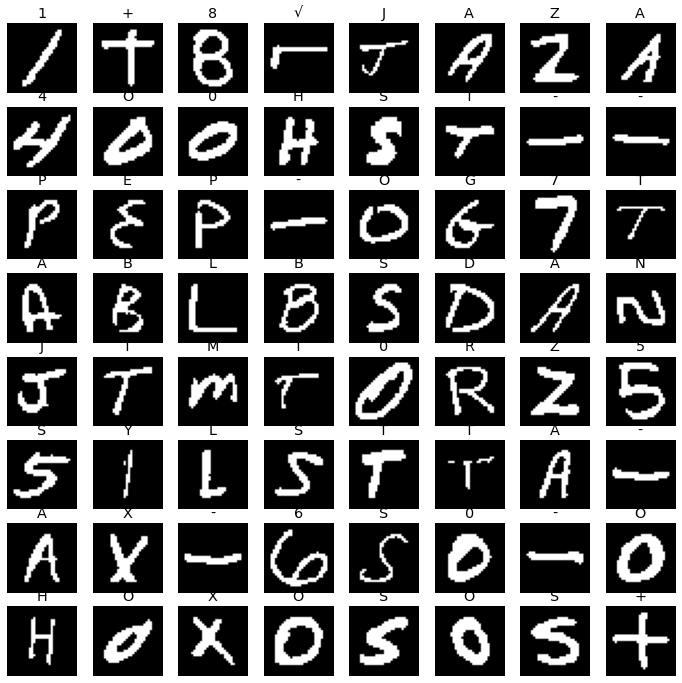

In [9]:
#? sample the model
model_images = x_test[:64]

model_predictions = model.predict(model_images)
model_lables = [lables[p.argmax()] for p in model_predictions]

fig = plt.figure(figsize=(12, 12))

for i in range(64):

    fig.add_subplot(8, 8, i+1)
    plt.axis('off')
    plt.title(model_lables[i])
    plt.imshow(model_images[i].reshape((32, 32)), 'gray')

In [10]:
#? save the model
model.save('./models/ocr')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ./models/ocr\assets
